# Initialization

In [1]:
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm as tqdm
import dask.array as da
import matplotlib
import matplotlib.pyplot as plt
import netCDF4

[Dask](https://dask.org/) provides support for parallel computing and larger-than-memory arrays, both features are very useful for this application. For further information, see [Dask's Documentation](https://docs.dask.org/en/latest/).

In [2]:
import dask
from dask.distributed import Client
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:59584 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 68.55 GB


# Layer-averaged quantities

The complete spatio-temporal analysis of the relevant quantities is possible in a layer averaged context per width unit, that is computed according to the equations

$$
Uh(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} u_1(x_1,x_2,x_3,t) ~ dx_2 dx_3
$$
$$
U^2h(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} \big( u_1(x_1,x_2,x_3,t) \big)^2 ~ dx_2 dx_3
$$
$$
UCh(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} u_1 (x_1,x_2,x_3,t) ~ c_t (x_1,x_2,x_3,t) ~ dx_2 dx_3
$$

For the vertical integration, $x_{2r}$ represents the bed position and $x_{2i}$ represents the interface between the underflow turbidity current and the ambient fluid, considered in this work as the position where $u_1 \times c_t = 0.005$. This step has been done in the previous example (see [00-LA-and-Convert-to-NetCDF.ipynb](00-LA-and-Convert-to-NetCDF.ipynb)), the datasets are available at [Zenodo](https://doi.org/10.5281/zenodo.3968993). After downloading them, the files for all cases can be loaded and concatenate in a single variable using:

In [4]:
ds = xr.open_mfdataset('LA-case-?.nc', concat_dim='case', combine='nested').compute()
ds = ds.assign_coords({'case': [2, 4, 5, 6, 7]})

And we can show in the screen all the variables in the `xarray.Dataset`:

In [5]:
ds

<xarray.Dataset>
Dimensions:  (case: 5, n: 3, t: 2401, x: 801, y: 121, z: 90)
Coordinates:
  * t        (t) float32 0.0 2.5 5.0 7.5 10.0 ... 5992.5 5995.0 5997.5 6000.0
  * z        (z) float32 0.0 0.26666668 0.53333336 ... 23.2 23.466667 23.733334
  * n        (n) int64 0 1 2
  * y        (y) float32 16.875 16.734375 16.59375 ... 0.28125 0.140625 0.0
  * x        (x) float32 0.0 0.3125 0.625 0.9375 ... 249.375 249.6875 250.0
  * case     (case) int32 2 4 5 6 7
Data variables:
    uset     (case, n) float64 1.9e-05 0.0009 0.0039 ... 1.9e-05 0.0009 0.0039
    Ri0      (case, n) float64 0.003153 0.003153 0.003153 ... 0.008767 0.008767
    Fr0      (case, n) float64 17.81 17.81 17.81 8.452 ... 10.68 10.68 10.68
    Sc       (case, n) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Re       (case) float64 4.3e+03 2.5e+03 3.3e+03 4.3e+03 4.3e+03
    S        (case) float64 0.05 0.05 0.05 0.05 0.05
    ramp     (case, x) float32 1.0 1.015625 1.03125 ... 13.46875 13.484375 13.5
    Uh       (case, x, t) float32 0.0 -1.0121834 ... -1.2522296 -1.2549425
    U2h      (case, x, t) float32 0.0 -1.0192424 ... -0.30240095 -0.3035403
    UCh      (case, x, t, n) float32 0.0 0.0 0.0 ... -0.2581251 -0.06844864
    utau     (case, x, t) float32 0.048941012 0.048703995 ... 0.015408344
    dep      (case, n, x, t) float32 0.0 6.311286e-06 ... 0.0006873559
Attributes:
    title:    The Plunging of Hyperpycnal Plumes on Tilted Bed by Three-Dimen...
    authors:  F. N. Schuch, J. H. Silvestrini, E. Meiburg & S. Laizet
    url:      https://github.com/fschuch/the-plunging-flow-by-3D-LES
    doi:      10.5281/zenodo.3968993

For further information see [Why xarray](http://xarray.pydata.org/en/stable/why-xarray.html), and off course, [xarray's Documentation](http://xarray.pydata.org/en/stable/).

For the specific case of the plunging flow configuration, the vertical coordinate was moved to the top of the computational domain, and it points down, so we need to inverse the signals before any other computation:

In [6]:
ds['Uh'] *= -1
ds['U2h'] *= -1
ds['UCh'] *= -1

And now, we can compute and plot all layer-averaged quantities:

* Layer-averaged Velocity:
$$
U(x_1,t) = \dfrac{U^2h}{Uh}
$$

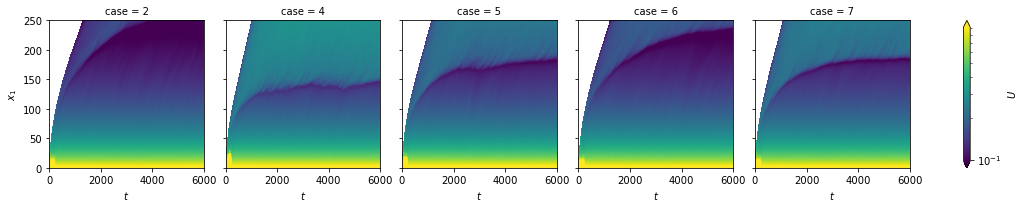

In [7]:
ds['U'] = ds.U2h/ds.Uh
ds.U.attrs = {'name': 'Layer-averaged Velocity', 'long_name': r'$U$'}
ds.U.plot(col='case', robust=True, norm=matplotlib.colors.LogNorm());

* Underflow depth:
$$
H(x_1,t) = \dfrac{(Uh)^2}{U^2h}
$$

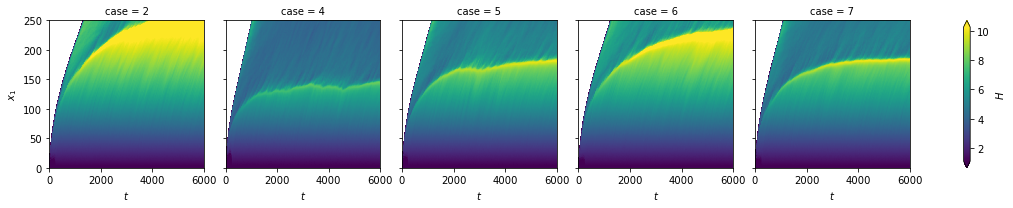

In [8]:
ds['H'] = ds.Uh**2./ds.U2h
ds.H.attrs = {'name': 'Flow depth', 'long_name': r'$H$'}
ds.H.plot(col='case', robust=True);

* Mixing coefficient:
$$
\gamma(x_1,t) = \dfrac{Uh}{1} - 1
$$

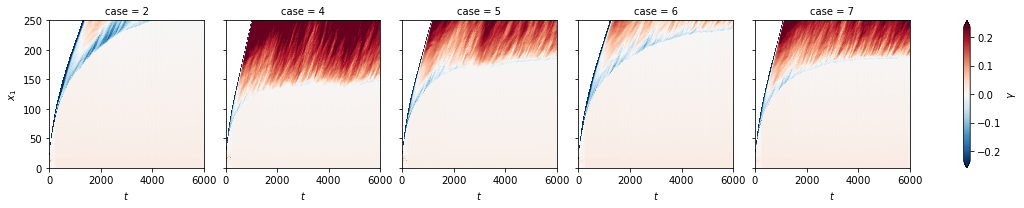

In [9]:
ds['mixing'] = ds.U*ds.H - 1.
ds.mixing.attrs = {'name': 'Mixing coefficient', 'long_name': r'$\gamma$'}
ds.mixing.plot(col='case', robust=True);

* Layer-averaged total concentration:
$$
C_t (x_1,t) = \sum \dfrac{UCh}{Uh}
$$

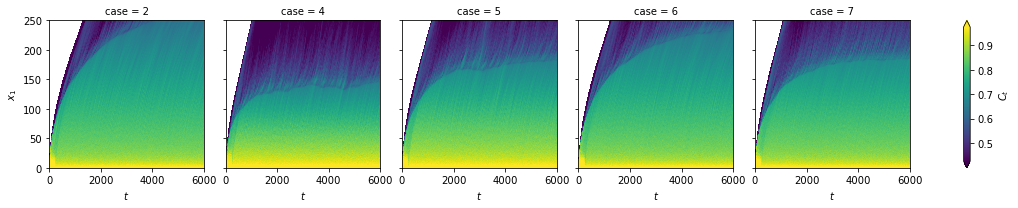

In [10]:
ds['C'] = ds.UCh.sum('n')/ds.Uh
ds.C.attrs = {'name': 'Layer-averaged total Concentration', 'long_name': r'$C_t$'}
ds.C.plot(col='case', robust=True);

* Densimetric Froude number:
$$
Fr(x_1,t) = \dfrac{Uh}{\sqrt{CH^3}}Fr_0
$$

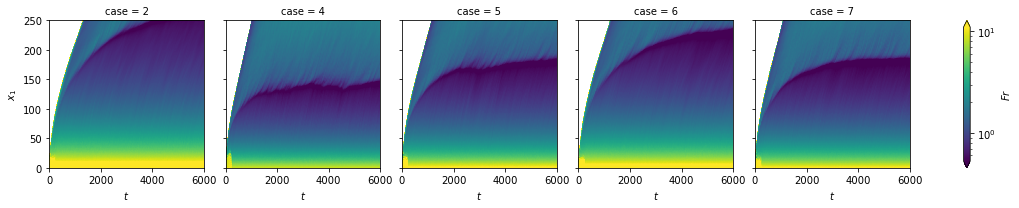

In [11]:
ds['Fr'] = ds.Fr0.mean('n')*ds.Uh*(ds.C**(-1./2.))*(ds.H**(-3./2.))
ds.Fr.attrs = {'name': 'Local densimetric Fround number', 'long_name': r'$Fr$'}
ds.Fr.plot(col='case', robust=True, norm=matplotlib.colors.LogNorm());

And plot the spanwise-avareged quantities:

* Bed shear velocity:

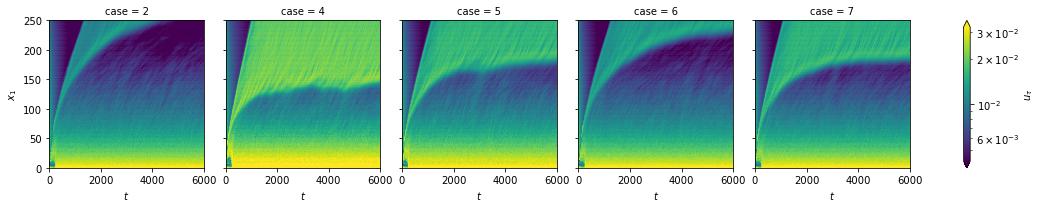

In [12]:
ds.utau.attrs = {'name': 'Bed shear velocity', 'long_name': r'$u_\tau$'}
ds.utau.plot(col='case', robust=True, norm=matplotlib.colors.LogNorm());

* Total deposition rate:

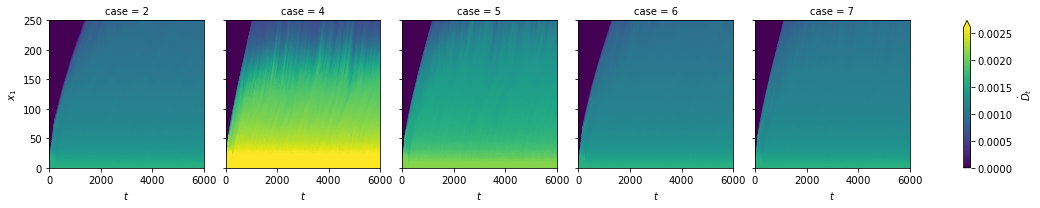

In [13]:
ds['dept'] = ds.dep.sum('n')
ds.dept.attrs = {'name': 'Total deposition rate', 'long_name': r'$\dot{D}_t$'}
ds.dept.plot(col='case', robust=True);

# Other

Some of the flow features can be obtained with the layer-averaged quantities, for instance:

* The plunge point is located where the densimetric Froude number is minimum:

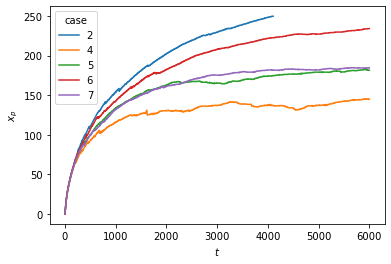

In [14]:
# Fill NaN with a large number just to avoid problems and get where it is minimum
ixp = ds.Fr.fillna(1e3).argmin(dim='x')

# Then obtain plunge point position (where it is inside the test section)
ds['xp'] = ds.x[ixp].where(ixp != ds.x.size - 1)

ds.xp.attrs = {'name': 'Distance for plunging', 'long_name': r'$x_p$'}
ds.xp.plot.line(x='t');

* Densimetric Frounde number at plunge point:

C:\Users\felip\anaconda3\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


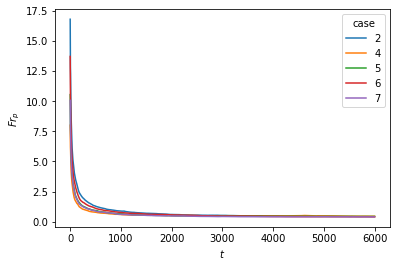

In [15]:
# It is the minimum value inside the test section
ds['Frp'] = ds.Fr.min(dim='x').where(ixp != ds.x.size - 1)

ds.Frp.attrs = {'name': 'Densimetric Frounde number at plunge point', 'long_name': r'$Fr_p$'}
ds.Frp.plot.line(x='t');

* Front position:

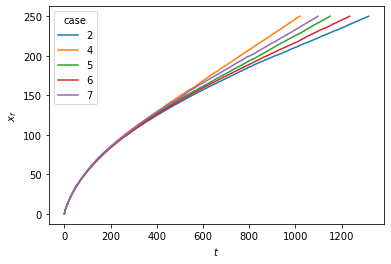

In [16]:
ixf = ds.Uh.argmin(dim='x')

ds['xf'] = ds.x[ixf].where(ds.t <= ds.t[ixf.argmax(dim='t')])
ds.xf.attrs = {'name': 'Front position', 'long_name': r'$x_f$'}
ds.xf.plot.line(x='t');

* Front velocity:
$$
u_f = \dfrac{d x_f}{d t}
$$

C:\Users\felip\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


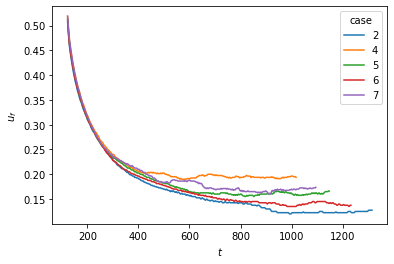

In [17]:
# a rolling average is used to reduce the noise
ds['uf'] = ds.xf.differentiate('t').rolling(t=50).mean()
ds.uf.attrs = {'name': 'Front velocity', 'long_name': r'$u_f$'}
ds.uf.plot.line(x='t');

# Flow evolution

Lets load the spanwise-averaged planes from case 4 as an example:

In [18]:
xyplanes = xr.load_dataset('xy-planes-case-4.nc')

In [19]:
xyplanes

<xarray.Dataset>
Dimensions:  (n: 3, t: 1201, x: 801, y: 121, z: 90)
Coordinates:
  * n        (n) int64 0 1 2
  * x        (x) float32 0.0 0.3125 0.625 0.9375 ... 249.375 249.6875 250.0
  * y        (y) float32 16.875 16.734375 16.59375 ... 0.28125 0.140625 0.0
  * z        (z) float32 0.0 0.26666668 0.53333336 ... 23.2 23.466667 23.733334
  * t        (t) float32 0.0 5.0 10.0 15.0 20.0 ... 5985.0 5990.0 5995.0 6000.0
Data variables:
    uset     (n) float64 3.2e-05 0.0016 0.0067
    Ri0      (n) float64 0.014 0.014 0.014
    Fr0      (n) float64 8.452 8.452 8.452
    Sc       (n) float64 1.0 1.0 1.0
    Re       float64 2.5e+03
    S        float64 0.05
    ramp     (x) float32 1.0 1.015625 1.03125 ... 13.46875 13.484375 13.5
    ux       (x, y, t) float32 0.0 0.0 0.0 ... -0.023010366 -0.022613643
    uy       (x, y, t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uz       (x, y, t) float32 0.0 0.0 0.0 ... 0.001034194 0.001030162
    phi      (n, x, y, t) float32 0.0 0.0 0.0 ... 5.4308202e-17 6.7705944e-17
Attributes:
    title:    The Plunging of Hyperpycnal Plumes on Tilted Bed by Three-Dimen...
    authors:  F. N. Schuch, J. H. Silvestrini, E. Meiburg & S. Laizet
    url:      https://github.com/fschuch/the-plunging-flow-by-3D-LES
    doi:      10.5281/zenodo.3968993

Now, lets select some values as time reference:

In [20]:
selected_times = [250, 500, 1000, 2000, 6000]

And plot total concentration field (notice that matplotlib can be used for adjustments):

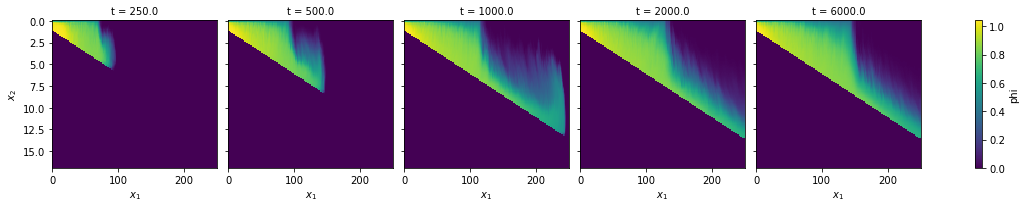

In [21]:
xyplanes.phi.sel(t=selected_times).sum('n').plot(col='t', x='x')
plt.gca().invert_yaxis()
plt.show();

Now the velocity components:

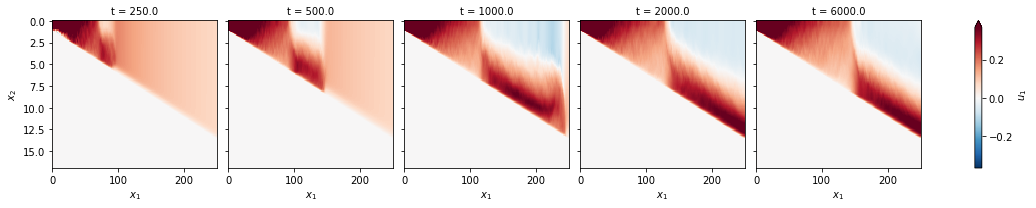

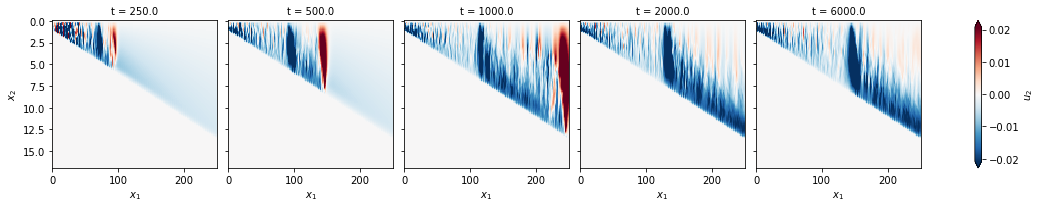

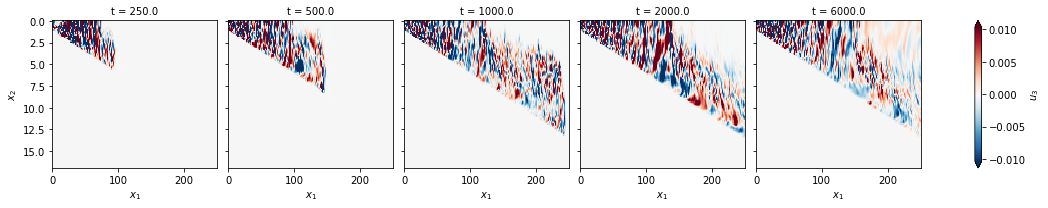

In [22]:
for var in 'ux uy uz'.split():
    xyplanes[var].sel(t=selected_times).plot(col='t', x='x', robust=True)
    plt.gca().invert_yaxis()
    plt.show();

We can extract a signal in some location:

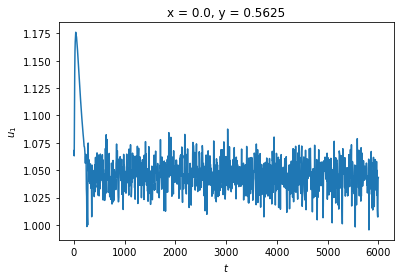

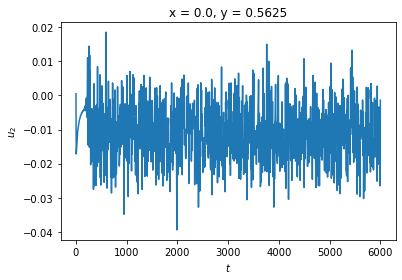

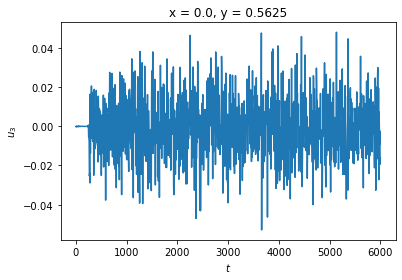

In [23]:
for var in 'ux uy uz'.split():
    xyplanes[var].sel(x=0, y=0.5, method='nearest').plot()
    plt.show()

and we can go back to `ds` and plot some variables for all cases at reference times:

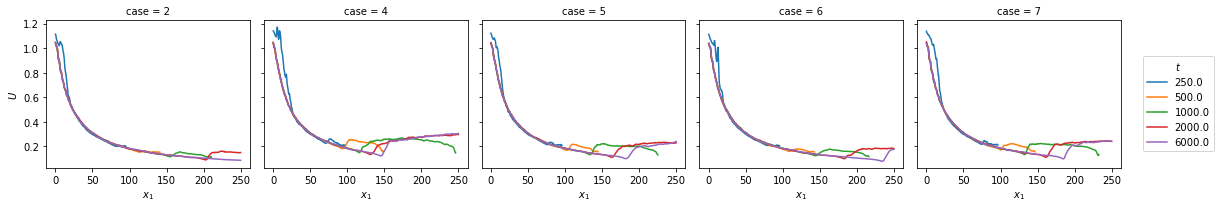

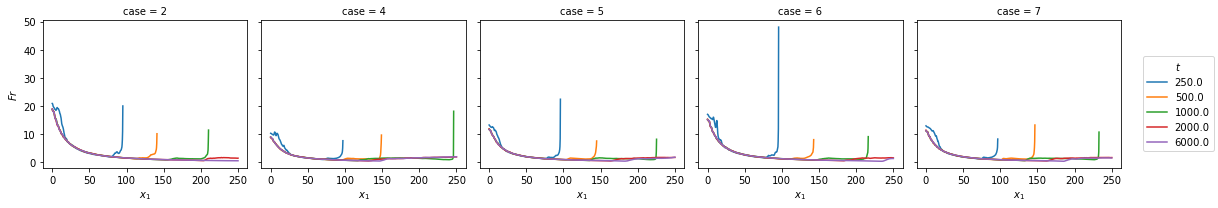

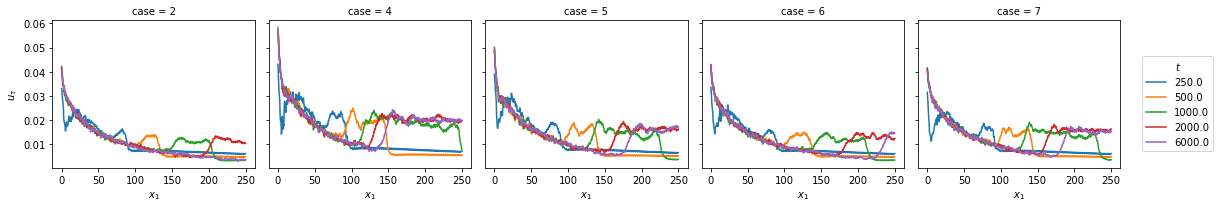

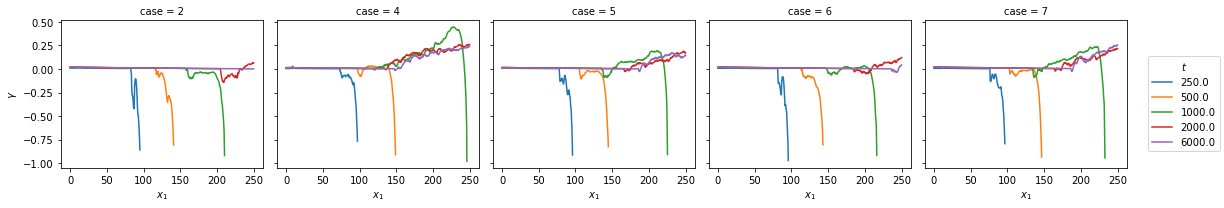

In [24]:
for var in 'U Fr utau mixing'.split():
    ds[var].sel(t=selected_times).plot(hue="t", x='x', col='case')
    plt.show();